# Анализ аренды самокатов GoFast

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
- без подписки
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

В основных данных есть информация о пользователях, их поездках и подписках.
Описание данных:

Пользователи — users_go.csv
- `user_id` -	уникальный идентификатор пользователя
- `name` -	имя пользователя
- `age` - возраст
- `city` -	город
- `subscription_type` -	тип подписки (free, ultra)

Поездки — rides_go.csv
- `user_id` -	уникальный идентификатор пользователя
- `distance` -	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` -	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` -	дата совершения поездки

Подписки — subscriptions_go.csv
- `subscription_type` -	тип подписки
- `minute_price` -	стоимость одной минуты поездки по данной подписке
- `start_ride_price` -	стоимость начала поездки
- `subscription_fee` -	стоимость ежемесячного платежа

#### Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import binom

In [2]:
users_go = pd.read_csv ('/datasets/users_go.csv')
rides_go = pd.read_csv ('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv ('/datasets/subscriptions_go.csv')

##### 1.1 Информация о датафрейме users_go

In [3]:
users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


 Датафрейм users_go содержит данные о 1565 клиентах, их возрасте, городе аренды и тип подписки.

##### 1.2 Информация о датафрейме rides_go

In [5]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Датафрейм rides_go содержит данные о 18068 сессиях использования самокатов.

##### 1.3 Информация о датафрейме subscriptions_go

In [7]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Датафрейм rides_go содержит данные о видах подписки и ее условиях.

#### Шаг 2. Предобработка данных

##### 2.1 Приведение столбца date к типу даты pandas

In [9]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')

##### 2.2 Создание нового столбца с номером месяца на основе столбца date

In [10]:
rides_go['date'].min()

Timestamp('2021-01-01 00:00:00')

In [11]:
rides_go['date'].max()

Timestamp('2021-12-30 00:00:00')

In [12]:
rides_go['month'] = rides_go['date'].dt.month

Имеются данные за 2021 год 

##### 2.3 Проверка наличия пропущенных значений в датафреймах

In [13]:
users_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [14]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [15]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Прупущенных значений не обнаружено. 

##### 2.4 Проверка наличия дубликатов  в датафреймах

In [16]:
users_go.duplicated().sum()

31

In [17]:
rides_go.duplicated().sum()

0

In [18]:
subscriptions_go.duplicated().sum()

0

Найден 31 дубликат в датафрейме users_go.

##### 2.5 Удаление дубликатов 

In [19]:
users_go = users_go.drop_duplicates()

**Вывод предобработки данных:**

Прупущенных значений не обнаружено.

Обработан 31 дубликат в датафрейме users_go.

#### Шаг 3. Исследовательский анализ данных

##### 3.1 Частота встречаемости городов

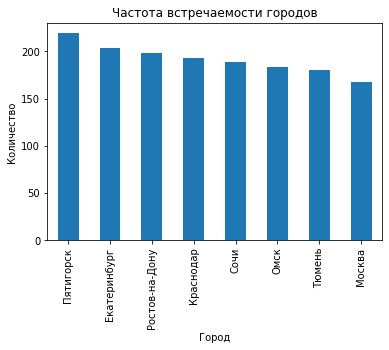

In [20]:
ax = users_go['city'].value_counts().plot.bar()

plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.show()

In [21]:
users_go['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Пятигорск, Екатеринбург и Ростов-на-Дону - лиды по количеству пользоватей, меньше всего пользователей в Москве.

##### 3.2 Cоотношение пользователей с подпиской и без подписки

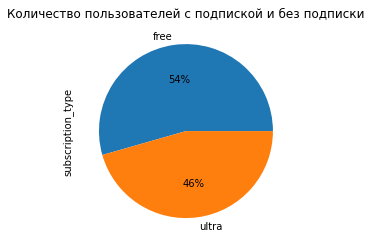

In [22]:
ax = users_go['subscription_type'].value_counts().plot(kind = 'pie',autopct = '%1.0f%%')

plt.title('Количество пользователей с подпиской и без подписки')
plt.show()

Большая часть пользователей (54%) использует сервис без подписки.

##### 3.3 Возраст пользователей

In [23]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

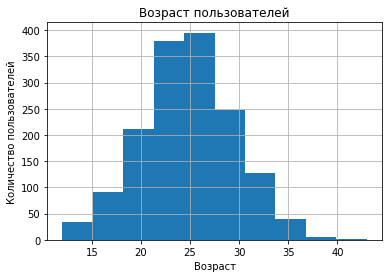

In [24]:
plt.hist(users_go['age'], bins = 10)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Возраст пользователей самокатов от 12 до 43 лет. Средний возраст потребителя услуги 25 лет.

##### 3.4 Расстояние, которое пользователь преодолел за одну поездку

In [25]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

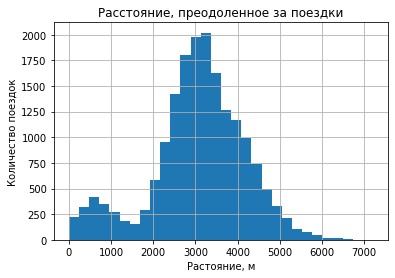

In [26]:
plt.hist(rides_go['distance'], bins = 30)
plt.title('Расстояние, преодоленное за поездки')
plt.xlabel('Растояние, м')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

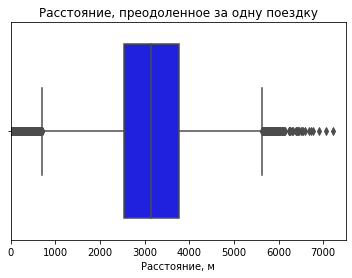

In [27]:
sns.boxplot(x=rides_go['distance'], color='blue')
plt.title('Расстояние, преодоленное за одну поездку')
plt.xlabel('Расстояние, м')
_ = plt.xlim(0, 7500)

За одну поездку пользователь преодолевает от 0,00086 (возможно часть пользователей начинают поедку и сразу заканчивают) до 7,2 км, чаще пользователи проезжают от 2,5 до 3,9 км.

##### 3.5 Продолжительность поездок

In [28]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

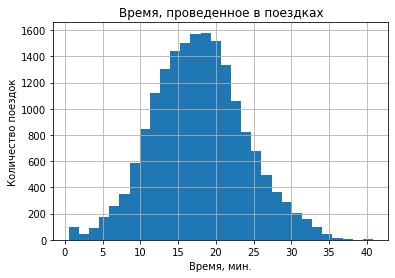

In [29]:
plt.hist(rides_go['duration'], bins = 30)
plt.title('Время, проведенное в поездках')
plt.xlabel('Время, мин.')
plt.ylabel('Количество поездок')
plt.grid()
plt.show()

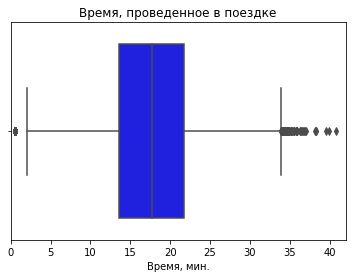

In [30]:
sns.boxplot(x = rides_go['duration'], color='blue')
plt.title('Время, проведенное в поездке')
plt.xlabel('Время, мин.')
_ = plt.xlim(0, 42)

Пользователи используют самокат от 0,5 до 40,8 мин. Большинство поездок составляет от 14 до 22 мин.

**Вывод анализа даннных:**

Пятигорск (219), Екатеринбург (204) и Ростов-на-Дону (198) - лиды по количеству пользоватей, меньше всего пользователей самокатов в Москве (168).

Большая часть пользователей (54%) использует сервис без подписки.

Возраст пользователей самокатов от 12 до 43 лет. Средний возраст потребителя услуги 25 лет.

За одну поездку пользователь преодолевает от 0,00086 (возможно часть пользователей начинают поедку и сразу заканчивают) до 7,2 км, в основном пользователи проезжают от 2,5 до 3,9 км.

Пользователи используют самокат от 0,5 до 40,8 мин. В основном продолжительность поездки составляет от 14 до 22 мин.

#### Шаг 4. Объединение данных

##### 4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм

In [31]:
all_go = users_go.merge(rides_go, on='user_id')

In [32]:
all_go = all_go.merge(subscriptions_go, on='subscription_type')
all_go.head(15)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [33]:
all_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [34]:
all_go.duplicated().sum()

0

In [35]:
all_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Кол-во строк совпадает с количеством строк датафрейма rides_go, пропусков и дубликатов не обнаружено. 

##### 4.2 Создание датафрейма c данными о пользователях БЕЗ подписки и визуализация информации о расстоянии и времени поездок для пользователей 

In [36]:
sub_free  = all_go[all_go['subscription_type'] == 'free']
sub_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [37]:
sub_free.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,6.522994,8.0,50.0,0.0
std,241.165628,4.481100,1246.173806,6.326803,3.449770,0.0,0.0,0.0
min,700.000000,12.000000,0.855683,0.500000,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2366.562689,12.958437,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3114.648465,17.326890,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3905.697894,21.594071,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.007745,34.948498,12.000000,8.0,50.0,0.0


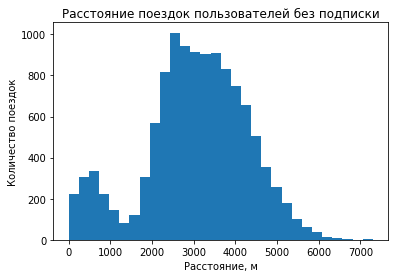

<Figure size 1440x1440 with 0 Axes>

In [38]:
plt.hist(sub_free['distance'], bins=30, range = (0, 7300))
plt.title('Расстояние поездок пользователей без подписки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Пользователи без подписки могли часто использовать самокаты для поездок на короткие расстояния, поэтому возник пик 

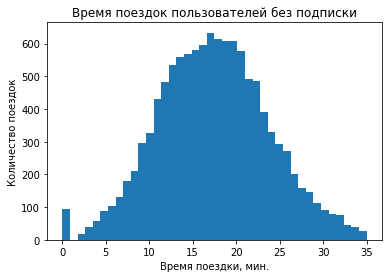

<Figure size 1440x1440 with 0 Axes>

In [39]:
plt.hist(sub_free['duration'], bins=40, range = (0, 35))
plt.title('Время поездок пользователей без подписки')
plt.xlabel('Время поездки, мин.')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

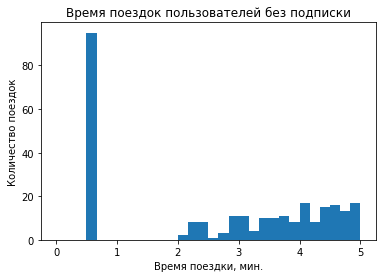

<Figure size 1440x1440 with 0 Axes>

In [40]:
plt.hist(sub_free['duration'], bins=30, range = (0, 5))
plt.title('Время поездок пользователей без подписки')
plt.xlabel('Время поездки, мин.')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Есть более 100 поездок с продолжительностью меньше минуты, не стоит включать эти данные в анализ

Пользователи без подписки в основном проезжают от 2 до 5 км и тратят от 10 до 30 мин.

##### 4.3 Создание датафрейма с данными о пользователях С подпиской и визуализация информации о расстоянии и времени поездок для пользователей 

In [41]:
sub_ultra  = all_go[all_go['subscription_type'] == 'ultra']
sub_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [42]:
sub_ultra.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,1.000000,12.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


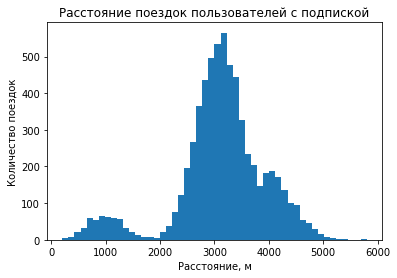

<Figure size 1440x1440 with 0 Axes>

In [43]:
plt.hist(sub_ultra['distance'], bins=50, range = (200, 5800))
plt.title('Расстояние поездок пользователей с подпиской')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

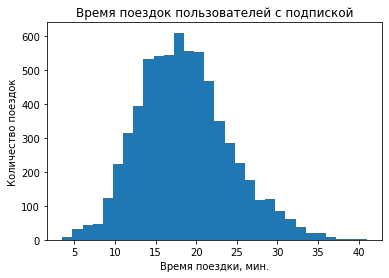

<Figure size 1440x1440 with 0 Axes>

In [44]:
plt.hist(sub_ultra['duration'], bins=30, range = (3.5, 41))
plt.title('Время поездок пользователей с подпиской')
plt.xlabel('Время поездки, мин.')
plt.ylabel('Количество поездок')
plt.figure(figsize=(20,20))
plt.show()

Пользователи с подпиской в основном проезжают от 2,7 до 4 км и тратят от 14 до 25 мин.

**Вывод:**
Медианное расстояние без подписки и с подпиской почти одиноково. Однако, пользователи без подписки проезжают большее расстояние, чем пользователи с подпиской.

Медианное значение продолжительности поездки больше у пользователей с подпиской.

#### Шаг 5. Подсчёт выручки

##### 5.1 Создание датафрейма с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4 с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц

In [45]:
# каждое значение из столбца duration округляется с помощью «потолка»: 
all_go['duration'] = np.ceil(all_go['duration']) 

In [46]:
#каждое значение из столбца duration округляется с помощью «потолка»
total_go = pd.pivot_table(all_go,
                           index=['user_id', 'month'],
                           values = ['distance', 'duration', 'name', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee'],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : 'count', 
                                      'subscription_type' : min,
                                      'minute_price' : min,
                                      'start_ride_price' : min,
                                      'subscription_fee' : min
                                     })

In [47]:
total_go.rename(columns = {'name' : 'count_tips'}, inplace = True)
total_go.head()

distance  duration  minute_price  count_tips  \
user_id month                                                    
1       1      7027.511294      42.0             6           2   
        4       754.159807       7.0             6           1   
        8      6723.470560      46.0             6           2   
        10     5809.911100      32.0             6           2   
        11     7003.499363      56.0             6           3   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra

##### 5.2 Определение помесячной выручки, которую принёс каждый пользователь

Помесячная выручка = стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.

In [48]:
# Расчет выручки
total_go['revenue'] = ((total_go['start_ride_price'] * total_go['count_tips']) 
    + (total_go['minute_price'] * total_go['duration']) 
    + total_go['subscription_fee']
)

total_go.head()

distance  duration  minute_price  count_tips  \
user_id month                                                    
1       1      7027.511294      42.0             6           2   
        4       754.159807       7.0             6           1   
        8      6723.470560      46.0             6           2   
        10     5809.911100      32.0             6           2   
        11     7003.499363      56.0             6           3   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra    451.0  
        4                     0               199             ultra    241.0  
        8                     0               199             ultra    475.0  
        10                    0               199             ultra    391.0  
        11                    0               199             ultra    535.0

In [49]:
total_go['revenue'].sum()

3878641.0

**Вывод:**
Общая выручка составила 3,88 млн

#### Шаг 6. Проверка гипотез

##### 6.1 Гипотеза 1: пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.

H_0: Средняя продолжительность поездок ultra и free равна

H_1: Средняя продолжительность поездок ultra больше, чем с free

In [50]:
ultra = sub_ultra['duration'] 
free = sub_free['duration']

results = st.ttest_ind(ultra, 
                       free,
                       alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Пользователи с подпиской «выгоднее» для компании.

##### 6.2 Гипотеза 2: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3 130 метров

H_0: Среднее расстояние поездок с использованием подписки ‘ultra’ равно оптимальному расстоянию в 3130 метров

H_1: Среднее расстояние поездок с использованием подписки ‘ultra’ больше оптимального расстояния в 3130 метров

In [51]:
ultra_dist = sub_ultra['distance']
optimal_dist = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    optimal_dist,
    alternative='greater')
    
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию в 3130 метров. Расстояние одной поездки в 3 130 метров — оптимальное с точки зрения износа самоката.

Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров 

##### 6.3 Гипотеза 3: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

H_0: Выручка от поездок с подпиской и без подписки равны

H_1: Выручка от поездок с подпиской больше, чем выручка от поездок без подписки

In [52]:
ultra_revenue = total_go.loc[total_go.subscription_type == 'ultra', 'revenue'] 
free_revenue = total_go.loc[total_go.subscription_type == 'free', 'revenue'] 

results = st.ttest_ind(ultra_revenue, 
                       free_revenue,
                       alternative = 'greater')

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

##### 6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применяется метод scipy.stats.ttest_rel().

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения

**Вывод:**

Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Пользователи с подпиской «выгоднее» для компании, так как активее используют сервис.

Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию в 3130 метров. Расстояние одной поездки в 3 130 метров — оптимальное с точки зрения износа самоката.

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Таким образом, результаты анализа данных позволяют сделать вывод о том, что пользователи с подпиской более выгодны для компании.

#### Шаг 7. Общий вывод

В ходе исследования проанализированы данные  популярного сервиса аренды самокатов GoFast о пользователях из нескольких городов, а также об их поездках и проверены некоторые гипотезы, которые могут помочь бизнесу вырасти.

В результате предобработки данных был обработан 31 дубликат, изменен тип данных в столбце date. Пропущенных значений не выявлено.

В ходе исследовательского анализа данных выявлено: 
- Пятигорск (219), Екатеринбург (204) и Ростов-на-Дону (198) - лиды по количеству пользоватей, меньше всего пользователей самокатов в Москве (168). 
- Большая часть пользователей (54%) использует сервис без подписки. 
- Возраст пользователей самокатов от 12 до 43 лет. Средний возраст потребителя услуги 25 лет. 
- За одну поездку пользователь преодолевает от 0,00086 (возможно часть пользователей начинают поедку и сразу заканчивают) до 7,2 км, в основном пользователи проезжают от 2,5 до 3,9 км. 
- Пользователи используют самокат от 0,5 до 40,8 мин. В основном продолжительность поездки составляет от 14 до 22 мин.

Сравнение пользователей без подписки и с подпиской показало, что пользователи без подписки проезжают большее расстояние, чем пользователи с подпиской, а медианное значение продолжительности поездки больше у пользователей с подпиской.

Общая выручка составила 3,88 млн.

Результате проверки гипотез показал:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе. Пользователи с подпиской «выгоднее» для компании, так как активее используют сервис. 
- Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию в 3130 метров. Расстояние одной поездки в 3 130 метров — оптимальное с точки зрения износа самоката. 
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Таким образом, результаты анализа данных позволяют сделать вывод о том, что пользователи с подпиской более выгодны для компании.